# Explore the effect of overlap size in asymmetric slicing embeddings for scenarios having different network-feature correlation

## Imports and setup

In [1]:
import time
import random
import os
from collections import defaultdict, Counter
import warnings
import functools
import pickle
import gc
import datetime

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import pandas as pd
import networkx as nx
import dask
import distributed

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback
from tqdm import tqdm_notebook as tqdm

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching
from nw2vec import generative
import settings

Using TensorFlow backend.


Some scenario, grid and path parameters

In [2]:
N_ALPHAS = 11
N_MODEL_SAMPLES = 20
N_CLUSTERINGS = 2
N_NODES = 1000
N_CLUSTERS = 100
COLORS_PATH = os.path.join(settings.BEHAVIOUR_PATH, 'colors')
RESULTS_PATH = (COLORS_PATH
                + '/S2_S3-ov_noov_asym-n_nodes={n_nodes}-n_clusters={n_clusters}'
                + '-n_alphas={n_alphas}-n_models={n_models}-n_clusterings={n_clusterings}'
                + '-spill_v2adj={spill_v2adj}'
                + '-{data_name}.pkl')
FIGURE_PATH = (COLORS_PATH
               + '/S2_S3-ov_noov_asym-n_nodes={n_nodes}-n_clusters={n_clusters}'
               + '-n_alphas={n_alphas}-n_models={n_models}-n_clusterings={n_clusterings}'
               + '-spill_v2adj={spill_v2adj}'
               + '-{data_name}.png')

Some training parameters

In [3]:
max_dim_ξ = 20
dim_l1 = max(max_dim_ξ, int(np.round(np.exp(np.mean(np.log([max_dim_ξ, N_CLUSTERS]))))))
SPILL_V2ADJS = range(10)
MODEL_OVERLAP = 'overlap'
MODEL_NOOVERLAP = 'no-overlap'

def get_loss_weights(n_nodes, dims, q_overlap):
    dim_data, _, dim_ξ_adj, dim_ξ_v = dims
    return {
        # embedding-gaussian divergence scales with number of embedding dimensions,
        # but we also don't want it to overpower the other losses, hence the 1e-2
        'q_mulogS_flat': 1000 * 1e-3 * 1.0 / (dim_ξ_adj - q_overlap + dim_ξ_v),
        # Adj loss scales with the number of nodes
        'p_adj': 1000 * 1.0 / (n_nodes * np.log(2)),
        # Feature loss scales with the average number of sampled colors
        'p_v': 1000 * 1.0 / np.log(dim_data),
    }

## Load results into a DataFrame and plot the results of the trainings

This is all standard Pandas+Seaborn code.

In [4]:
all_results = defaultdict(list)

for spill_v2adj in SPILL_V2ADJS:
    # Load the results for this particular spill_v2adj
    results_file = RESULTS_PATH.format(n_nodes=N_NODES, n_clusters=N_CLUSTERS,
                                       n_alphas=N_ALPHAS, n_models=N_MODEL_SAMPLES, n_clusterings=N_CLUSTERINGS,
                                       spill_v2adj=spill_v2adj,
                                       data_name='histories')
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
    
    # Start filling the all_results dict, and remember the ids of the best training epoch
    min_ids = np.zeros(len(results), dtype=int)
    for i, (((aid, cid), (model_type, spill_v2adj, ref_ov, sampling_id)), history) in enumerate(results.items()):
        for title, values in history.items():
            if title != 'loss':
                continue
            all_results['alpha_id'].append(aid)
            all_results['clustering_id'].append(cid)
            all_results['loss'].append(title)
            all_results['weighted best'].append(values.min())
            min_ids[i] = values.argmin()
            all_results['model_type'].append(model_type)
            all_results['spill_v2adj'].append(spill_v2adj)
            all_results['dim_ξ'].append(max_dim_ξ - ref_ov)
            all_results['ref_ov'].append(ref_ov)
            all_results['sampling_id'].append(sampling_id)

    for i, (((aid, cid), (model_type, spill_v2adj, ref_ov, sampling_id)), history) in enumerate(results.items()):
        # Recover adj/v dimensions and actual overlap (= q_overlap), in order to get the loss scaling weights
        if model_type == MODEL_OVERLAP:
            dims = (N_CLUSTERS, dim_l1,
                    max_dim_ξ // 2 + spill_v2adj,
                    max_dim_ξ // 2 - spill_v2adj)
            q_overlap = ref_ov
        else:
            assert model_type == MODEL_NOOVERLAP
            dims = (N_CLUSTERS, dim_l1,
                    max_dim_ξ // 2 + spill_v2adj - ref_ov // 2,
                    max_dim_ξ // 2 - spill_v2adj - ref_ov // 2)
            q_overlap = 0
        loss_weights = get_loss_weights(N_NODES, dims, q_overlap)
        
        for title, values in history.items():
            if title == 'loss':
                continue
            all_results['alpha_id'].append(aid)
            all_results['clustering_id'].append(cid)
            all_results['loss'].append(title)
            all_results['weighted best'].append(values[min_ids[i]] * loss_weights[title[:-5]])
            all_results['model_type'].append(model_type)
            all_results['spill_v2adj'].append(spill_v2adj)
            all_results['dim_ξ'].append(max_dim_ξ - ref_ov)
            all_results['ref_ov'].append(ref_ov)
            all_results['sampling_id'].append(sampling_id)

all_results = pd.DataFrame(all_results)

In [5]:
all_results_orig = all_results

In [6]:
all_results_long = all_results.pivot_table(columns='loss',
                                           index=['alpha_id', 'clustering_id', 'model_type',
                                                  'spill_v2adj', 'dim_ξ', 'ref_ov', 'sampling_id'],
                                           values='weighted best')
all_results_long['adj_v_loss'] = all_results_long['p_adj_loss'] + all_results_long['p_v_loss']
all_results = all_results_long.stack().reset_index().rename(columns={0: 'weighted best'})

In [19]:
all_results_rel_spill = all_results.pivot_table(columns='spill_v2adj',
                                                index=['alpha_id', 'clustering_id', 'model_type',
                                                       'ref_ov', 'sampling_id', 'loss'],
                                                values='weighted best')
all_results_rel_spill = all_results_rel_spill.apply(
    lambda x: x / all_results_rel_spill[0])
all_results_rel_spill = all_results_rel_spill.stack().reset_index().rename(columns={0: 'weighted best'})

Absolute

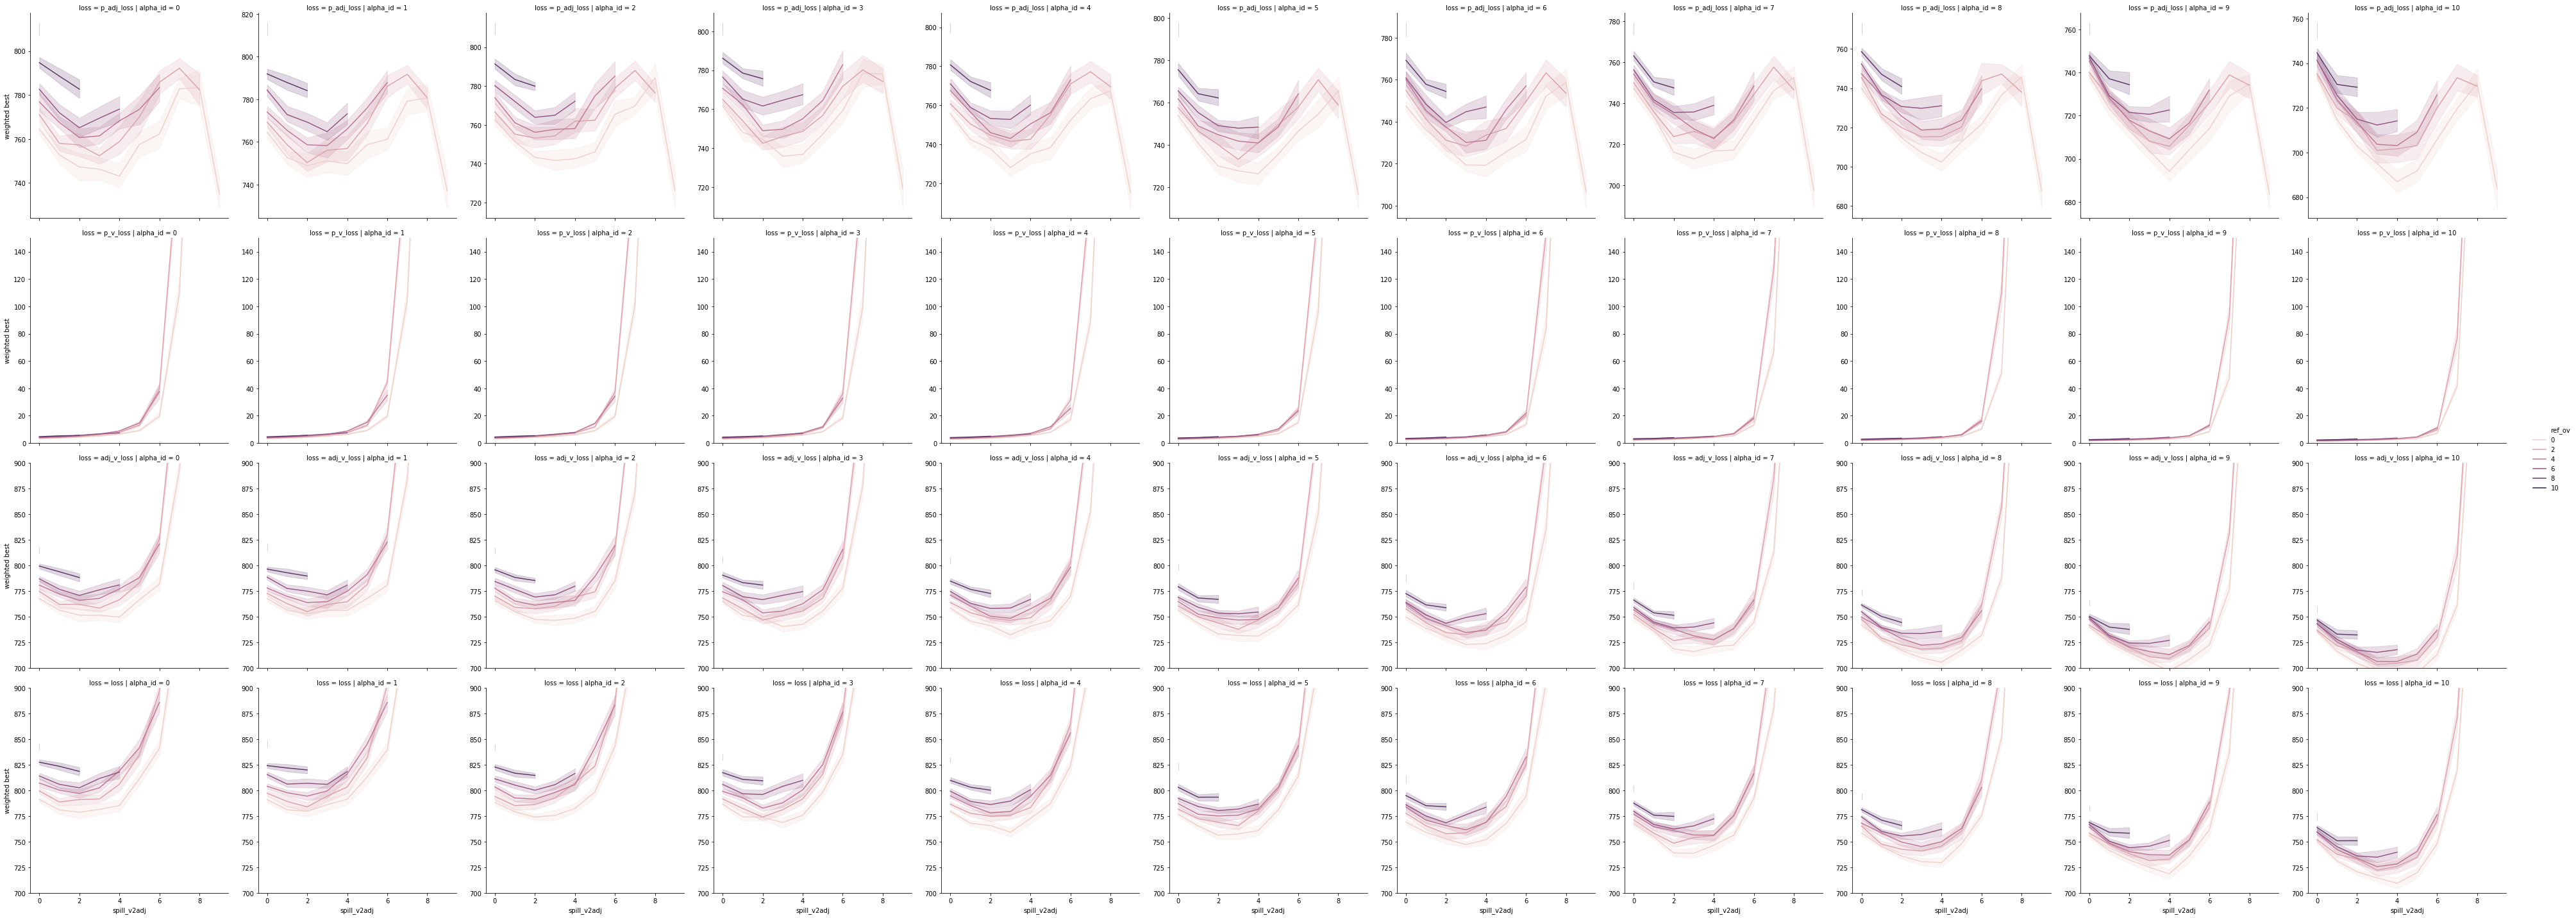

In [26]:
facet_grid = sb.relplot(x='spill_v2adj', y='weighted best',
                        hue='ref_ov',
                        col='alpha_id',
                        row='loss', row_order=['p_adj_loss', 'p_v_loss', 'adj_v_loss', 'loss'],
                        data=all_results[(all_results.model_type == MODEL_OVERLAP)
                                         & (all_results.clustering_id == 1)],
                        kind='line', legend='full', facet_kws={'sharey': False})

#facet_grid.set(yscale='log')

for ax in facet_grid.axes[1]:
    ax.set_ylim(0, 150)
for ax in facet_grid.axes[2:4].flat:
    ax.set_ylim(700, 900)

Relative

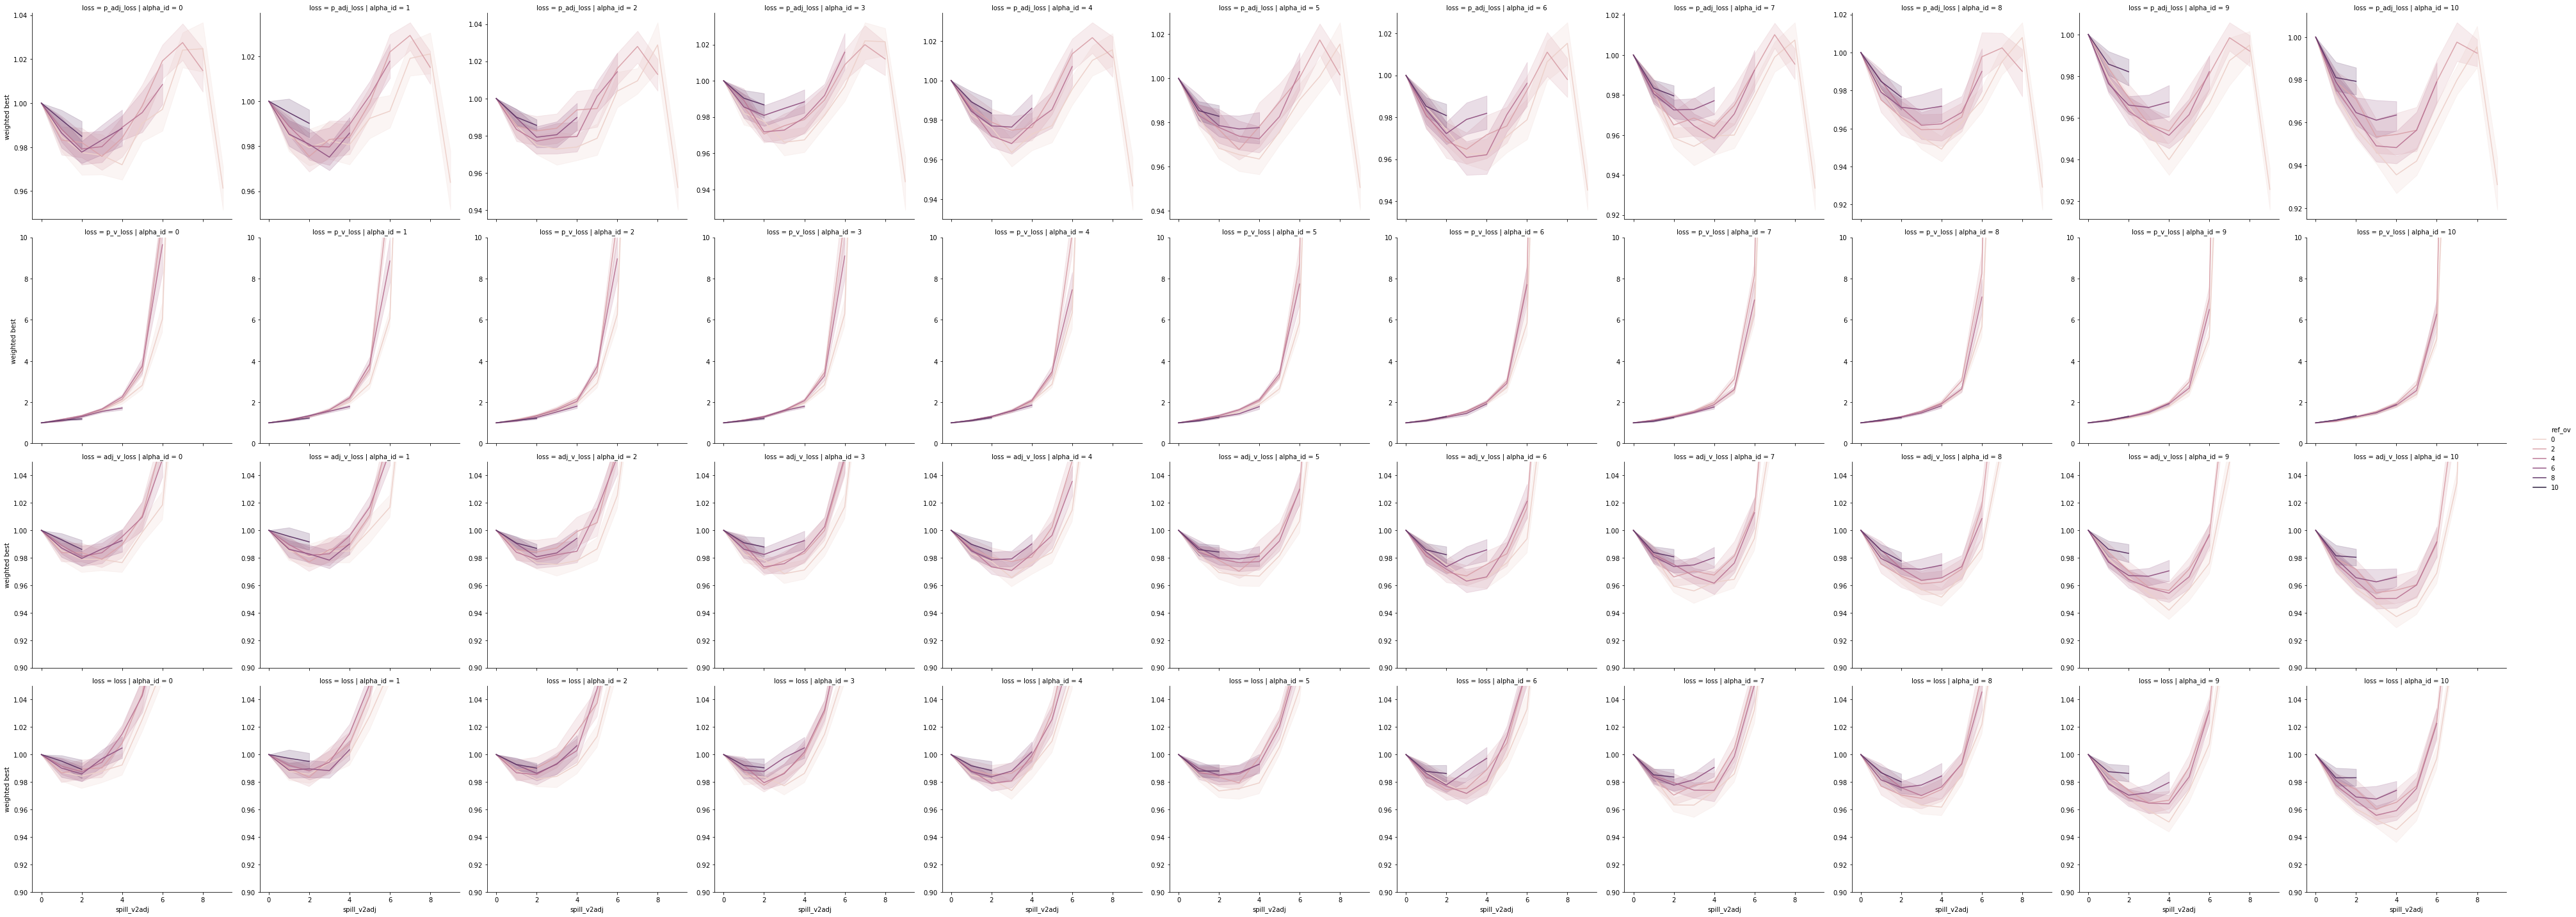

In [32]:
facet_grid = sb.relplot(x='spill_v2adj', y='weighted best',
                        hue='ref_ov',
                        col='alpha_id',
                        row='loss', row_order=['p_adj_loss', 'p_v_loss', 'adj_v_loss', 'loss'],
                        data=all_results_rel_spill[(all_results_rel_spill.model_type == MODEL_OVERLAP)
                                                   & (all_results_rel_spill.clustering_id == 1)],
                        kind='line', legend='full', facet_kws={'sharey': False})

#facet_grid.set(yscale='log')

for ax in facet_grid.axes[1]:
    ax.set_ylim(0, 10)
for ax in facet_grid.axes[2:4].flat:
    ax.set_ylim(0.9, 1.05)